In [2]:
from anastruct import SystemElements
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from ipywidgets import interact, widgets
from typing import Tuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing parameters

In [3]:
def pol2cart(l : float, th: float, phi: float):
    """
    Convert polar information to cartesian translation

    Parameters:
        l (float): linkage's length in mm
        th (float): angle in degrees

    Returns:
        Tuple[float, float]: Converted cartesian translation
    """

    th = np.deg2rad(th)
    phi = np.deg2rad(phi)

    # Calculate Cartesian coordinates
    x = l * np.sin(th) * np.cos(phi)
    y = l * np.sin(th) * np.sin(phi)
    z = l * np.cos(th)
    return np.array([x, y, z], dtype=float)

In [4]:
# Function to update the plot
class Create_Plot():
    def __init__(self):
        # Create sliders for joint angles
        self.th1_slider = widgets.FloatSlider(value=60, min=-180, max=180, step=1, description='Theta1 (degrees)', orientation='horizontal', layout=widgets.Layout(width='auto', height='auto'))
        self.th2_slider = widgets.FloatSlider(value=85, min=-180, max=180, step=1, description='Theta2 (degrees)', orientation='horizontal', layout=widgets.Layout(width='auto', height='auto'))

        self.prev_th1 = self.th1_slider.value
        self.prev_th2 = self.th2_slider.value

        # Create interactive plot with additional constant variables
        interact(self.update_plot, th1=self.th1_slider, th2=self.th2_slider)

    def update_plot(self, th1, th2):

        j1, j2, j3, j4, j5 = forward_kinematics(th1, th2)
        
        plt.figure(figsize=(10, 8))
        
        plt.plot([j1[0], j2[0], j3[0], j4[0], j3[0], j5[0], j1[0]], [j1[1], j2[1], j3[1], j4[1], j3[1], j5[1], j1[1]], marker='o', linestyle='-', color='b')
        plt.title("Biped Robot Forward Kinematics")
        plt.xlabel('X-axis (m)')
        plt.ylabel('Y-axis (m)')
        plt.grid(True)
        
        # Set aspect ratio to be equal
        plt.axis('equal')
        
        # Set specific axis limits
        plt.xlim([-0.3, 0.3])  # Set your desired X-axis limits
        plt.ylim([-0.5, 0.1])  # Set your desired Y-axis limits
        
        # plt.show()

# Create_Plot()

In [5]:
# Circle Equations and Find Intersection to close the loop

def circle_equations(params: Tuple[float, float], center1: np.ndarray, r1: float, center2: np.ndarray, r2: float) -> Tuple[float, float]:
    """
    System of equations representing the circles.

    Parameters:
        params (Tuple[float, float]): Coordinates (x, y) of the point to evaluate.
        center1 (np.ndarray): Center of the first circle.
        r1 (float): Radius of the first circle.
        center2 (np.ndarray): Center of the second circle.
        r2 (float): Radius of the second circle.

    Returns:
        Tuple[float, float]: Residuals for the system of equations.
    """
    x, y = params
    eq1 = (x - center1[0])**2 + (y - center1[1])**2 - r1**2
    eq2 = (x - center2[0])**2 + (y - center2[1])**2 - r2**2
    return np.array([eq1, eq2], dtype=float)

def find_circle_intersection(center1: np.ndarray, r1: float, center2: np.ndarray, r2: float) -> np.ndarray:
    """
    Find the intersection points of two circles using the Levenberg-Marquardt algorithm.

    Parameters:
        center1 (np.ndarray): Center of the first circle.
        r1 (float): Radius of the first circle.
        center2 (np.ndarray): Center of the second circle.
        r2 (float): Radius of the second circle.

    Returns:
        np.ndarray: Coordinates of the intersection points.
    """
     # Find the rightmost point among the two circles
    rightmost_point = max(center1[0] + r1, center2[0] + r2)

    # Initial guess (to the right of each circle center)
    current = np.array([rightmost_point, 0.0])

    # Use Levenberg-Marquardt to find the roots
    result = least_squares(circle_equations, current, args=(center1, r1, center2, r2))

    return result.x

def angle_between_vectors(v1, v2):
    """
    Find the angle (in degrees) between two vectors.

    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.

    Returns:
        float: Angle between the two vectors in degrees.
    """
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    cosine_angle = dot_product / (norm_v1 * norm_v2)
    angle_in_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_in_degrees = np.degrees(angle_in_radians)

    # Calculate the cross product to determine the direction
    cross_product = np.cross(v1, v2)

    # If the cross product is positive --> clockwise
    if cross_product > 0:
        angle_in_degrees *= -1

    return angle_in_degrees


In [6]:
def forward_kinematics(th1: float, th2: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform forward kinematics for the biped

    Parameters:
        th1 (float): Joint angle 1 in radians.
        th2 (float): Joint angle 2 in radians.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Joint coordinates (j1, j2, j3, j4, j5).
    """

    th1 = th1 + 180

    th_s = 180       # Theta shin

    s = 1            # Scale

    l1 = 55.34 / 1000 * s
    l2 = 105 / 1000 * s
    l3 = 105 / 1000 * s
    l4 = 105 / 1000 * s
    l5 = 55.34 / 1000 * s

    j1 = np.array([0, 0])
    j2 = j1 + pol2cart(l1, th1)
    j3 = j2 + pol2cart(l2, th1 + th2)

    j5 = find_circle_intersection(j1, l4, j3, l5)   # Closing the loop

    j4 = j3 + pol2cart(l3, (th_s + np.rad2deg(np.arctan2(j5[1] - j3[1], j5[0] - j3[0]))))   # end-effector position

    return j1, j2, j3, j4, j5

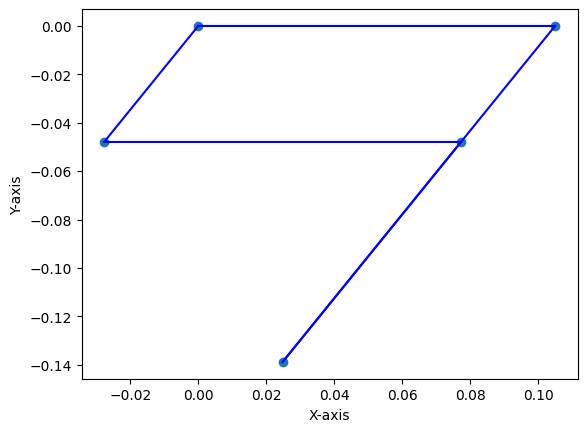

In [13]:
j1,j2,j3,j4,j5 = forward_kinematics(60, 120)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot()

# Plot joints
ax.scatter(*zip(j1, j2, j3, j4, j5), marker='o', label='Joints')

# Connect joints with lines
ax.plot([j1[0], j2[0]], [j1[1], j2[1]], color='b')
ax.plot([j2[0], j3[0]], [j2[1], j3[1]], color='b')
ax.plot([j3[0], j4[0]], [j3[1], j4[1]], color='b')
ax.plot([j4[0], j5[0]], [j4[1], j5[1]], color='b')
ax.plot([j5[0], j1[0]], [j5[1], j1[1]], color='b')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')

# Show plot
plt.show()

In [8]:
# Gradient Descent
def error_function(desired_pos: np.ndarray, current: np.ndarray) -> float:
    th1, th2 = current
    current_pos = forward_kinematics(th1, th2)[3]
    error = np.linalg.norm(current_pos - desired_pos)
    # print(th1, th2)
    # print(error)
    return error

def inverse_kinematics(desired: np.ndarray, angles_guess: Tuple[float, float], max_iterations: int = 50, learning_rate: int = 10000) -> Tuple[float, float]:
    """
    Perform inverse kinematics using gradient descent.

    Parameters:
        desired (np.ndarray): Target end-effector position [x, y].
        angles_guess (Tuple[float, float]): current joint angles.
        max_iterations (int): Maximum number of iterations for gradient descent.
        learning_rate (float): Learning rate for gradient descent.

    Returns:
        Tuple[float, float]: Joint angles (th1, th2).
    """
    angle1, angle2 = angles_guess

    step1 = 0.5
    step2 = 0.5

    tolerance = 0.001 # stop when the error is less than this or when weve done max_iterations
    iter = 0

    for _ in range(max_iterations):
        # error is the distance between the desired point and our current point. We want to minimize this.
        error = error_function(desired, np.array([angle1, angle2]))
        
        # step in a direction to find the error of the 2 angles
        error_angle1 = error_function(desired, np.array([angle1+step1, angle2]))
        error_angle2 = error_function(desired, np.array([angle1, angle2+step2]))

        # this is the gradient
        grad1 = (error_angle1 - error) / step1
        grad2 = (error_angle2 - error) / step2

        # step in the direction of the gradient. grad is the slope (rate of change), error is the distance, so in theory grad*error is the distance we want to step to get to the desired point in one step, but lmao no, multiply by really small fraction. 0.00001 is the largest that doesnt overshoot.
        angle1 -= grad1 * error * learning_rate
        angle2 -= grad2 * error * learning_rate

        iter += 1

        # print(grad1, grad2)
        # print(iter)
        
        # every other iteration, step in the opposite direction. When the leg is up against 2 of the 4 walls, the gradient descent will get stuck trying to step into the wall and getting a gradient of 0.
        step1 *= -1
        step2 *= -1

        if abs(error) < tolerance:
            break
    
    return angle1, angle2

Building Trusses

In [ ]:
desired_pos = np.array([0, -0.3])
guess = np.array([56, 120])
theta1, theta2 = inverse_kinematics(desired_pos, guess)

In [ ]:
n1, n2, n3, n4, n5 = forward_kinematics(theta1, theta2)


ss = SystemElements()

ss.add_truss_element(location=[n1, n2])
ss.add_truss_element(location=[n1, n5])
ss.add_truss_element(location=[n2, n3])
ss.add_truss_element(location=[n5, n3])
ss.add_truss_element(location=[n3, n4])

# Motor Torques:
T1 = 40 * 9.8/100           # Convert 40 kgcm to Nm
T2 = 80 * 9.8/100

ss.moment_load(node_id=[1], Ty=T1)
ss.moment_load(node_id=[2], Ty=-T2)

# Main body's weight:
Wt = 0 * 9.8                # Convert kg to N
# ss.point_load(node_id=[1], Fx=Wt, rotation=90)

ss.add_support_hinged(node_id=[5,1])

ss.solve()
ss.show_structure()
ss.show_reaction_force()

In [ ]:
print(ss.get_node_results_system(node_id=5)['Fy'] * -1 / 9.8)